In [1]:
import torch
from torch_geometric.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

from gnn import GNN

import os
from tqdm import tqdm
import argparse
import time
import numpy as np
import random

torch.cuda.is_available()

True

### hard-coded arguments

explain GCN model

In [2]:
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.checkpoint_dir = "checkpoint"
args.device = 0

In [3]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
# device = "cpu"
device

device(type='cuda', index=0)

In [4]:
shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


### load model

In [5]:
from gnn import GNN

In [6]:
"""
LOAD Checkpoint data
"""
checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'checkpoint.pt'))
checkpoint

{'epoch': 10,
 'model_state_dict': OrderedDict([('gnn_node.atom_encoder.atom_embedding_list.0.weight',
               tensor([[-0.0070,  0.4733, -0.5016,  ..., -0.1851,  0.1217,  0.1224],
                       [-0.1166,  0.3726, -0.0687,  ..., -0.4926, -0.1549, -0.2870],
                       [ 0.0401, -0.0115, -0.0072,  ..., -0.0628,  0.0563,  0.0835],
                       ...,
                       [-0.0571,  0.0159,  0.0011,  ...,  0.0244, -0.0200,  0.0333],
                       [-0.0164, -0.0172,  0.0837,  ...,  0.0640,  0.0729, -0.0326],
                       [-0.0652,  0.0050,  0.0020,  ...,  0.0402,  0.0093, -0.0330]],
                      device='cuda:0')),
              ('gnn_node.atom_encoder.atom_embedding_list.1.weight',
               tensor([[-0.0057,  0.1436, -0.2069,  ..., -0.0602, -0.0150,  0.1488],
                       [-0.0316, -0.0139,  0.0699,  ...,  0.0701, -0.0874, -0.2683],
                       [-0.0034, -0.0382,  0.0182,  ...,  0.0912, -0.0584, -0.

In [7]:
gnn_type = "gcn"

In [8]:
model = GNN(gnn_type = gnn_type, virtual_node = False, **shared_params).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.state_dict()

OrderedDict([('gnn_node.atom_encoder.atom_embedding_list.0.weight',
              tensor([[-0.0070,  0.4733, -0.5016,  ..., -0.1851,  0.1217,  0.1224],
                      [-0.1166,  0.3726, -0.0687,  ..., -0.4926, -0.1549, -0.2870],
                      [ 0.0401, -0.0115, -0.0072,  ..., -0.0628,  0.0563,  0.0835],
                      ...,
                      [-0.0571,  0.0159,  0.0011,  ...,  0.0244, -0.0200,  0.0333],
                      [-0.0164, -0.0172,  0.0837,  ...,  0.0640,  0.0729, -0.0326],
                      [-0.0652,  0.0050,  0.0020,  ...,  0.0402,  0.0093, -0.0330]],
                     device='cuda:0')),
             ('gnn_node.atom_encoder.atom_embedding_list.1.weight',
              tensor([[-0.0057,  0.1436, -0.2069,  ..., -0.0602, -0.0150,  0.1488],
                      [-0.0316, -0.0139,  0.0699,  ...,  0.0701, -0.0874, -0.2683],
                      [-0.0034, -0.0382,  0.0182,  ...,  0.0912, -0.0584, -0.3024],
                      [-0.0125,  0.0622,

In [9]:
model.eval()

GNN(
  (gnn_node): GNN_node(
    (atom_encoder): AtomEncoder(
      (atom_embedding_list): ModuleList(
        (0): Embedding(119, 600)
        (1): Embedding(4, 600)
        (2): Embedding(12, 600)
        (3): Embedding(12, 600)
        (4): Embedding(10, 600)
        (5): Embedding(6, 600)
        (6): Embedding(6, 600)
        (7): Embedding(2, 600)
        (8): Embedding(2, 600)
      )
    )
    (convs): ModuleList(
      (0): GCNConv(
        (linear): Linear(in_features=600, out_features=600, bias=True)
        (root_emb): Embedding(1, 600)
        (bond_encoder): BondEncoder(
          (bond_embedding_list): ModuleList(
            (0): Embedding(5, 600)
            (1): Embedding(6, 600)
            (2): Embedding(2, 600)
          )
        )
      )
      (1): GCNConv(
        (linear): Linear(in_features=600, out_features=600, bias=True)
        (root_emb): Embedding(1, 600)
        (bond_encoder): BondEncoder(
          (bond_embedding_list): ModuleList(
            (0): 

### load data

In [10]:
### importing OGB-LSC
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

dataset = PygPCQM4MDataset(root = 'dataset/')

In [11]:
split_idx = dataset.get_idx_split()
split_idx["train"], split_idx["test"], split_idx["valid"]

(tensor([      0,       1,       2,  ..., 3045357, 3045358, 3045359]),
 tensor([3426030, 3426031, 3426032,  ..., 3803450, 3803451, 3803452]),
 tensor([3045360, 3045361, 3045362,  ..., 3426027, 3426028, 3426029]))

In [12]:
""" 
IMPORTANT: GRAPH QUERY ID
Pick the graph
"""
selectedID = 75088 #0 #131054
queryID = split_idx["valid"][selectedID:selectedID + 1]
queryID

tensor([3120448])

In [13]:
# valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
valid_loader = DataLoader(dataset[queryID], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
valid_loader

In [14]:
list(valid_loader)

[Batch(batch=[12], edge_attr=[24, 3], edge_index=[2, 24], ptr=[2], x=[12, 9], y=[1])]

## predict

In [15]:
batch = list(valid_loader)[0]
data = batch[0]
data

Data(edge_attr=[24, 3], edge_index=[2, 24], x=[12, 9], y=[1])

In [16]:
batch = batch.to(device)
with torch.no_grad():
    pred = model(batch).view(-1,)
    
pred

tensor([2.9520], device='cuda:0')

In [17]:
y_true = data.y.item()
y_pred = pred.item()
y_true, y_pred

(8.582470893859863, 2.951965570449829)

## plot sample

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

In [19]:
def plotGraph(data, y_pred, y_true, ax, printnodelabel=False, printedgelabel=False):

    edges = data.edge_index.T.tolist()
    edges = np.array(edges)
    edges = [(x[0][0], x[0][1], {"feat": str(x[1])}) for x in list(zip(edges.tolist(), data.edge_attr.tolist()))]
    nodes = [(x[0], {"feat": str(x[1])}) for x in enumerate(data.x.tolist())]

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nodelabels = nx.get_node_attributes(G, 'feat') 
    edgelabels = nx.get_edge_attributes(G, "feat")

    pos = nx.spring_layout(G)
    ax.set_title("pred={:.2f}, true={:.2f}".format(y_pred, y_true))
    if printnodelabel:
        nx.draw(G, pos, labels=nodelabels, ax=ax, node_size=40)
    else:
        nx.draw(G, pos, ax=ax, node_size=40)
        
    if printedgelabel:
        nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edgelabels)


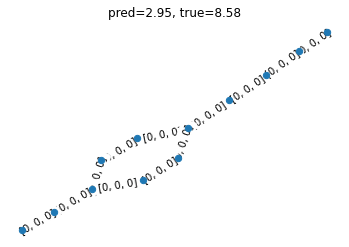

In [20]:
fig, ax = plt.subplots()
plotGraph(data, y_pred, y_true, ax, False, True)

## perturb edge feature

edge (5, 6, 2) possible dimensions

In [24]:
import ogb.utils as utils

In [25]:
edgeFeatDims = utils.features.get_bond_feature_dims()
edgeFeatDims

[5, 6, 2]

In [26]:
perturb_data_list = []

for _ in range(5000):
    # clone original data
    pData = data.clone()
    
    # create random noise
    randomNoise = np.random.randint(low=-4, high=4, size=data.edge_attr.shape)
    randomNoise = torch.tensor(randomNoise)

    # add edge_attr noise
    pData.edge_attr += randomNoise
    
    pData.edge_attr[:, 0] = pData.edge_attr[:, 0].clip(0, edgeFeatDims[0]-1)
    pData.edge_attr[:, 1] = pData.edge_attr[:, 1].clip(0, edgeFeatDims[1]-1)
    pData.edge_attr[:, 2] = pData.edge_attr[:, 2].clip(0, edgeFeatDims[2]-1)
    
    perturb_data_list.append(pData)
    
len(perturb_data_list)

5000

In [27]:
valid_loader = DataLoader(perturb_data_list, batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

# get data
batch = list(valid_loader)[0]
batch = batch.to(device)
with torch.no_grad():
    pred = model(batch) #.view(-1,)
    
pred.shape

torch.Size([256, 1])

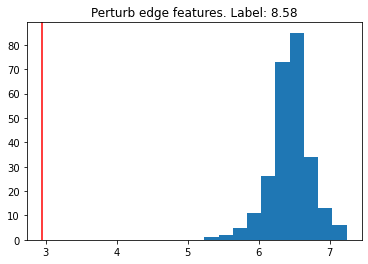

In [28]:
plt.title("Perturb edge features. Label: {:.2f}".format(y_true))
plt.hist(pred.view(-1).tolist())
plt.axvline(y_pred, c="r")
plt.show()

given fixed node features and topology, perturbing edge features don't disturb the output much

## perturb node features


In [82]:
nodeDims = utils.features.get_atom_feature_dims()
nodeDims

[119, 4, 12, 12, 10, 6, 6, 2, 2]

In [83]:
perturb_data_list = []

for _ in range(1000):
    # clone original data
    pData = data.clone()
    
    # create random noise
    randomNoise = np.random.randint(low=-1, high=1, size=data.x.shape)
    randomNoise = torch.tensor(randomNoise)

    # add edge_attr noise
    pData.x += randomNoise
    
    pData.x[:, 0] = pData.x[:, 0].clip(0, nodeDims[0]-1)
    pData.x[:, 1] = pData.x[:, 1].clip(0, nodeDims[1]-1)
    pData.x[:, 2] = pData.x[:, 2].clip(0, nodeDims[2]-1)
    pData.x[:, 3] = pData.x[:, 2].clip(0, nodeDims[3]-1)
    pData.x[:, 4] = pData.x[:, 2].clip(0, nodeDims[4]-1)
    pData.x[:, 5] = pData.x[:, 2].clip(0, nodeDims[5]-1)
    pData.x[:, 6] = pData.x[:, 2].clip(0, nodeDims[6]-1)
    pData.x[:, 7] = pData.x[:, 2].clip(0, nodeDims[7]-1)
    pData.x[:, 8] = pData.x[:, 2].clip(0, nodeDims[8]-1)
    
    perturb_data_list.append(pData)
    
len(perturb_data_list)

1000

In [78]:
# perturb_data_list = [data]

# for i in range(1):
#     pData = data.clone()
# #     pData.x[-1, 0] = torch.tensor(i)
#     pData.x[-1] = torch.tensor([ 5,  0,  4,  5,  3,  0,  2,  0,  0])
#     perturb_data_list.append(pData)


In [85]:
valid_loader = DataLoader(perturb_data_list, batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

# get data
batch = list(valid_loader)[0]
batch = batch.to(device)
with torch.no_grad():
    pred = model(batch) #.view(-1,)
    
pred.shape #, pred

torch.Size([256, 1])

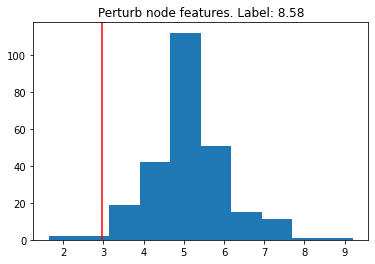

In [86]:
plt.title("Perturb node features. Label: {:.2f}".format(y_true))
plt.hist(pred.view(-1).tolist())
plt.axvline(y_pred, c="r")
plt.show()

node features seem very sensitive

## perturb topology

In [87]:
# keep backup
backup = data.edge_index.clone()
backup

tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          7, 10, 10, 11,  9,  4],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  7, 11, 10,  4,  9]])

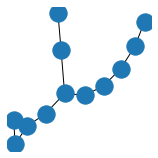

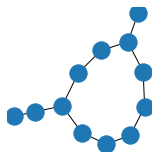

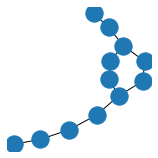

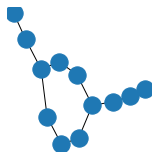

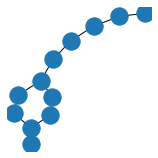

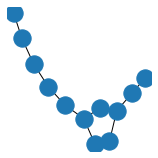

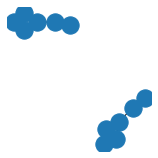

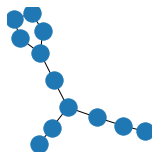

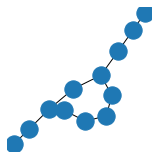

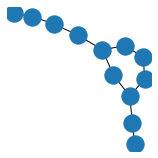

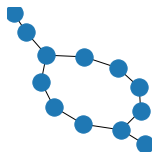

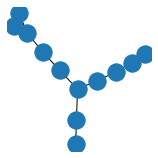

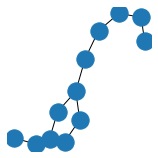

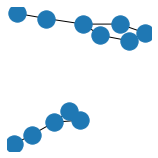

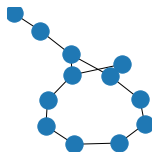

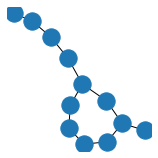

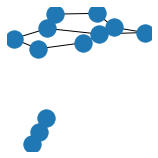

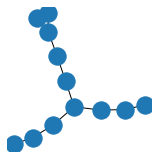

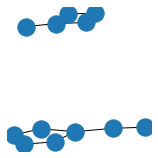

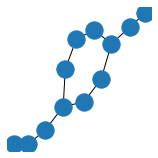

1000

In [88]:
perturb_data_list = []

for i in range(1000):
    # clone original data
    pData = data.clone()
    
    # noise parameters
    noEdgeSwap = 3

    # create edges
    edges = pData.edge_index.T.tolist()
    edges = np.array(edges)
    edges = [(x[0][0], x[0][1], {"feat": str(x[1])}) for x in list(zip(edges.tolist(), pData.edge_attr.tolist()))]
    nodes = [(x[0], {"feat": str(x[1])}) for x in enumerate(pData.x.tolist())]
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # swap edges
    G = nx.double_edge_swap(G, noEdgeSwap)
    # both directions
    newEdges = list(G.edges()) + [(x[1], x[0]) for x in G.edges()]
    newEdges = torch.tensor(newEdges).T
    # set value
    pData.edge_index = newEdges

    perturb_data_list.append(pData)
    
    # visualise some graphs
    if i % 50 == 0:
        plt.figure(figsize=(2, 2))
        nx.draw(G)
        plt.show()
    
len(perturb_data_list)

In [89]:
valid_loader = DataLoader(perturb_data_list, batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

# get data
batch = list(valid_loader)[0]
batch = batch.to(device)
with torch.no_grad():
    pred = model(batch) #.view(-1,)
    
pred.shape

torch.Size([256, 1])

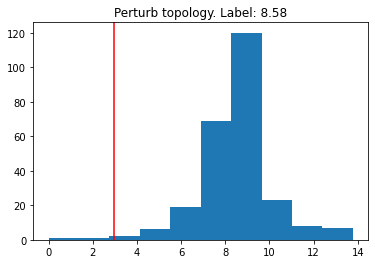

In [90]:
plt.title("Perturb topology. Label: {:.2f}".format(y_true))
plt.hist(pred.view(-1).tolist())
plt.axvline(y_pred, c="r")
plt.show()

topology doesn't seem to affect the score too